In [2]:
# import needed packages
%matplotlib inline
import numpy as np, matplotlib.pylab as plt, seaborn as sns, mpmath as mp, scipy.special as ss, sys, datetime
import scipy.stats as stats
sys.path.append('os.getcwd()')
import geopandas as gp, pandas as pd, urllib2
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from pdf_ccdf import pdf_ccdf
import warnings
warnings.filterwarnings("ignore")
from a_b_functions import getFlowFileList as getFlow
import pickle
import numpy as np, matplotlib.pylab as plt, pandas as pd, urllib2
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
import os
import glob

In [3]:

def g(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]


def KirchnerG(q,a,b,c):
    return np.exp(a*np.log(q)**2 + b*np.log(q) + c)


def KirchnerBinning(df, loud=False):
    df = df.sort_values(by='q',ascending=False)

    logQ = np.array(np.log(df.q))

    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*.01

    binBoundaries = [0]
    for i in range(1,len(df)):
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
            if loud: print('Bin too small')
            continue

        curr = df.Dunsmooth[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
            if loud: print('Bin too heterogeneous')
            continue

        binBoundaries.append(i)

    return binBoundaries


def _finditem(obj, key):
    if key in obj: return obj[key]
    for k, v in obj.items():
        if isinstance(v,dict):
            return _finditem(v, key)


def kirchner_fitter(sample, option=1, start=1, selectivity=200, window=3, minLen=5, ax=None):

    dateList = []
    blist = []
    alist = []
    d = pd.DataFrame({'q': sample})
    dates = d.index
    selector = (d.q.max()-d.q.min())/selectivity
    [maxtab, mintab]=peakdet(d.q, selector)
    d['peaks']=-1
    d.ix[maxtab[:,0].astype(int),'peaks']=maxtab[:,1]
    d['smooth']= d.q.rolling(window).mean(); d['smooth'][0:2] = d.q[0:2]
    d['Dunsmooth']= d.q.diff().shift(-1)
    d['DDsmooth']=d['smooth'].diff().shift(-1).diff().shift(-1)
    d['DDunsmooth'] = d.q.diff().shift(-1).diff().shift(-1)
    d = d[:-2]

    #boolean vector for recession periods
    if option==0:
        d['choose']=d['Dunsmooth']<=0
    else:
        d['choose']=(d['Dunsmooth']<0) & ((d['DDsmooth']>=0)|(d['DDunsmooth']>=0))

    datesMax = d.ix[d['peaks']>0].index
    def func(t, q0, a, b):
            return ((-1+b)*(q0**(1-b)/(b-1)+a*t))**(1/(1-b))
    for i in np.arange(len(datesMax)-1):
        recStart = datesMax[i]; peak1 = datesMax[i]+start; peak2 = datesMax[i+1]
        recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
        if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
            continue
        t = np.arange(len(d.q[recStart:recEnd]))
        q0_data = d.q.loc[recStart]
        try:
            popt, cov = curve_fit(func,t,d.q[recStart:(recEnd)],[q0_data, .1, 1.5])
            if (popt[2]>0)&(popt[2]<10):
                alist.append(popt[1])
                blist.append(popt[2])

        except RuntimeError:
            print('Error encountered in fitting')

        dateList.append(dates[i])

    # Perform Kirchner fitting
    # if fittingType == 'KirchnerBins':
    recessions = d.loc[d.choose]
    binBoundaries = KirchnerBinning(d.loc[d.choose])
    qs = [np.mean(recessions.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)]
    dqs =   np.array([np.mean(recessions.Dunsmooth[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
    sigmas = np.array([np.std(recessions.Dunsmooth[binBoundaries[i]:binBoundaries[i+1]])/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)])
    sigmas = np.ones(np.shape(sigmas))
    p = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=2, w=1/(sigmas+1e-12))
    p_powerlaw = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=1, w=1/(sigmas+1e-12))
    bcurr = p_powerlaw[0]
    acurr = np.exp(p_powerlaw[1])
    tau = d.q.mean()**(1-bcurr) / acurr
    p[1] = p[1]-1

    if ax != None:
        ax.plot(np.log(qs), np.log(-dqs), c='g', alpha=0.5, lw=0, marker='o', label='log(-dq/dt)')
        ax.plot(np.log(qs), p_powerlaw[1] + p_powerlaw[0]*np.log(qs), label='power law')
        ax.plot(np.sort(np.log(qs)), p[2] + (p[1]+1)*np.sort(np.log(qs)) + p[0]*np.sort(np.log(qs))**2, label='kirchner quadratic', c='k')
        ax.legend(frameon=True, fancybox=True, loc=0)
        ax.set_title('b = %g, tau = %g' % (bcurr, tau))
        ax.set_ylabel('log(-dq/dt)')
        ax.set_xlabel('log(q)')

    # elif fittingType == 'KirchnerNonlinear':
    #     ## use the linear coefficients as the init cond for the nonlinear solver
    #     p = np.polyfit(np.log(recessions.q),np.log(-recessions.dq/recessions.q),2)
    #     p, cov = curve_fit(lambda x, a, b, c: KirchnerG(x,a,b,c), recessions.q, -recessions.dq/recessions.q, p0=p)
    # else:
    #     p = np.polyfit(np.log(recessions.q),np.log(-recessions.dq/recessions.q),2)

    return acurr, bcurr, p, dateList, alist, blist


In [4]:
flow_files = getFlow()

n_list = ['A', 'B', 'datedict', 'B_pdf', 'nu_pdf', 'MU_E', 'LAM_H', 'ALPHA_H', 'NU_K', 'NU_K_BSE', 'MU_KT', 'MU_T', 'R2B', 'R2B_K', 'A_EVENT', 'B_EVENT']

p = {}

seasons = ['spring', 'summer', 'fall', 'winter', 'wet', 'annual']

site_data = gp.read_file('./USGS_Streamgages-NHD_Locations.shp')

for season in seasons:
    p_list = {'A': {}, 'B': {}, 'datedict': {}, 'B_pdf': {}, 'nu_pdf': {}, 'MU_E': {}, 'LAM_H': {}, 'ALPHA_H': {}, 'NU_K': {}, 'NU_K_BSE': {}, 'MU_KT': {}, 'MU_T': {}, 'R2B': {}, 'R2B_K': {}, 'A_EVENT': {}, 'B_EVENT': {}}
    
    for fh in flow_files:
        
        snowfrac = pickle.load( open('./snow_fraction.p','rb') )
        site = fh.split('/')[-1][:8]
        try: 
            if snowfrac.loc[site] > 0.01: 
                continue
        except:
            continue

        try:
            res = pickle.load(open('results/'+site+'_results.p','rb'))
        except:
            continue

        try:
            for key, val in enumerate(res):
                p_list[n_list[key]][site] = val[(site, season)]
                
                if key == 0: 
                    df = pd.read_csv(fh, delim_whitespace=True, header=-1)
                    df.columns = ['gagenum', 'Year', 'Month', 'Day', 'q', 'e']
                    df['date'] = df[['Year', 'Month', 'Day']].apply(lambda s : datetime.datetime(*s),axis = 1)
                    df = df[['q', 'date']]
                    df.set_index('date', inplace=True)
                    df['date'] = df.index
                    df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
                    df.q *= 2.447e9 #cm^3/day
                    area = float(site_data['DA_SQ_MILE'].loc[site_data.SITE_NO==site])*2.58998811e10 #cm^2
                    df.q = df.q/area # cm/day
                    df = df.loc[df.q>0]

                    if season == 'winter':
                        tw = len(pd.date_range('12-2015', '3-2016'))
                        d = df.q.loc[(df.index.month>=12)|(df.index.month<=2)]
                    elif season == 'spring': 
                        tw = len(pd.date_range('3-2016', '6-2016'))
                        d = df.q.loc[(df.index.month>=3)&(df.index.month<=5)]
                    elif season == 'summer':
                        tw = len(pd.date_range('6-2016', '9-2016'))
                        d = df.q.loc[(df.index.month>=6)&(df.index.month<=8)]
                    elif season == 'fall':
                        tw = len(pd.date_range('9-2016', '12-2016'))
                        d = df.q.loc[(df.index.month>=9)&(df.index.month<=11)]
                    elif season == 'wet':
                        tw = len(pd.date_range('11-2016', '4-2017'))
                        d = df.q.loc[(df.index.month>=11)|(df.index.month<=4)]
                    elif season == 'annual':
                        tw = 365
                        d = df.q.loc[(df.index.month>=1)|(df.index.month<=12)]

                    sample = np.asarray(df.q.values).astype(float)
                    A_hat, B_hat, P_hat, dateList, alist, blist = kirchner_fitter(sample)
                    p_list['A_EVENT'][site] = np.median(np.array(alist).astype(float))
                    p_list['B_EVENT'][site] = np.median(np.array(blist).astype(float))       
 
        except:
            continue
            
    p[season] = pd.DataFrame(p_list)
    
dp = pd.Panel(p)

Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encountered in fitting
Error encounte

In [16]:
# dp['fall']

(-1, 1.5)

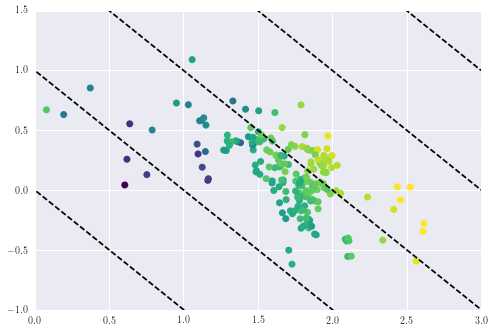

In [43]:
seasons = [
    'spring', 
#     'summer', 
#     'fall', 
    'winter', 
    'wet', 
#     'annual'
]

for season in seasons:
    df = dp[season]
    mu = np.asarray(df.MU_E.values).astype(float)
    tau_ind = np.asarray(mu**(1.-df.B_EVENT) / df.A_EVENT).astype(float)
    alpha = np.asarray(df.ALPHA_H.values).astype(float)
    b_ind = np.asarray(df.B_EVENT).astype(float)
    b_pdf = np.asarray(df.B_pdf).astype(float)
    b_k = np.asarray(df.B).astype(float)
    nu = np.asarray(df.nu_pdf.values).astype(float)
#     nu = np.asarray(df.NU_K.values).astype(float)
    nu[nu>=99] = np.nan
    nu[b_pdf < 1.1] = np.nan
    nu[b_pdf > 2.5] = np.nan
    
    
    colors = np.log10(alpha/tau_ind)

    plt.scatter(np.log10(mu*365), np.log10(nu), c=colors, vmin=-2., vmax=0., cmap=plt.cm.viridis, lw=0)
    
x = np.linspace(-3, 3, 10)
for ii in range(5):
    plt.plot(x, -x + ii, 'k--')
    
    
plt.xlim(0, 3)
plt.ylim(-1, 1.5)

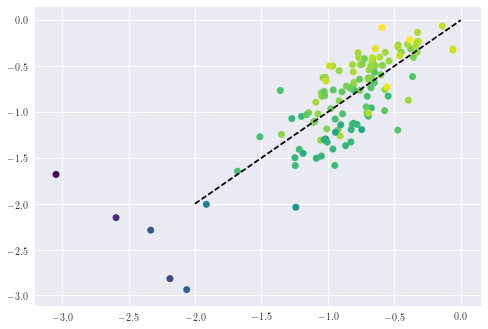

In [65]:
seasons = [
    'spring', 
    'summer', 
#     'fall', 
#     'winter', 
#     'wet', 
#     'annual'
]

for season in seasons:
    df = dp[season]
    mu = np.asarray(df.MU_E.values).astype(float)
    tau_ind = np.asarray(mu**(1.-df.B_EVENT) / df.A_EVENT).astype(float)
    alpha = np.asarray(df.ALPHA_H.values).astype(float)
    b_ind = np.asarray(df.B_EVENT).astype(float)
    b_pdf = np.asarray(df.B_pdf).astype(float)
    b_k = np.asarray(df.B).astype(float)
    nu = np.asarray(df.nu_pdf.values).astype(float)
#     nu = np.asarray(df.NU_K.values).astype(float)
    nu[nu>=99] = np.nan
    nu[b_pdf < 1.1] = np.nan
    nu[b_pdf > 2.5] = np.nan
    
    colors = np.log10(alpha)
#     colors = b_pdf
    plt.scatter(np.log10(nu*mu), np.log10(alpha/(tau_ind)), c=colors, vmin=-2, vmax=.5, cmap=plt.cm.viridis, lw=0)
    
#     colors = np.log10(alpha)
#     plt.scatter(np.log10(nu*mu*365), np.log10(alpha/tau_ind), c=colors, vmin=-1., vmax=.5, cmap=plt.cm.viridis, lw=0)
#     sns.jointplot(np.log10(nu*mu*365), np.log10(alpha/tau_ind), kind='kde')
    
    
x = np.linspace(-2, 0, 10)
plt.plot(x, x, 'k--')
    
    
# plt.xlim(0, 3)
# plt.ylim(-1, 1.5)

(0, 3)

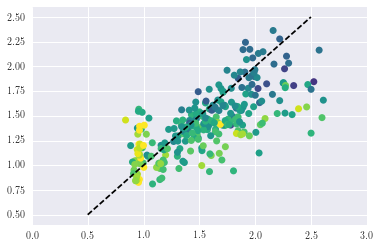

In [281]:
seasons = [
    'spring', 
#     'summer', 
#     'fall', 
    'winter', 
    'wet', 
#     'annual'
]

for season in seasons:
    df = dp[season]
    mu = np.asarray(df.MU_E.values).astype(float)
    tau_ind = np.asarray(mu**(1.-df.B_EVENT) / df.A_EVENT).astype(float)
    alpha = np.asarray(df.ALPHA_H.values).astype(float)
    b_ind = np.asarray(df.B_EVENT).astype(float)
    b_pdf = np.asarray(df.B_pdf).astype(float)
    b_k = np.asarray(df.B).astype(float)
    nu = np.asarray(df.nu_pdf.values).astype(float)
    nu[nu==100] = np.nan
    nu[nu>1000] = np.nan
    
    b_pdf[nu==np.nan] = np.nan
    
    colors = np.log10(nu)
    plt.scatter(b_pdf, b_k, c=colors, vmin=-1, vmax=1, cmap=plt.cm.viridis, lw=0)
#     plt.scatter(np.log10(mu*365), np.log10(nu), c=colors, vmin=-2.5, vmax=0, cmap=plt.cm.viridis, lw=0)
    
#     colors = np.log10(alpha)
#     plt.scatter(np.log10(nu*mu*365), np.log10(alpha/tau_ind), c=colors, vmin=-1., vmax=.5, cmap=plt.cm.viridis, lw=0)
#     sns.jointplot(np.log10(nu*mu*365), np.log10(alpha/tau_ind), kind='kde')
    
    
x = np.linspace(0.5, 2.5, 10)
plt.plot(x, x, 'k--')
    
    
plt.xlim(0, 3)
# plt.ylim(0.5, 4)

(-1, 1)

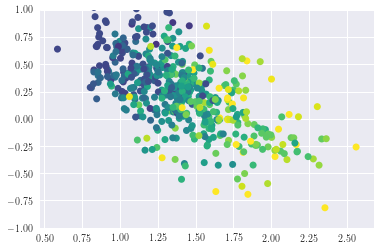

In [262]:
seasons = [
    'spring', 
    'summer', 
    'fall', 
    'winter', 
    'wet', 
    'annual'
]

for season in seasons:
    df = dp[season]
    mu = np.asarray(df.MU_E.values).astype(float)
    tau_ind = np.asarray(mu**(1.-df.B_EVENT) / df.A_EVENT).astype(float)
    alpha = np.asarray(df.ALPHA_H.values).astype(float)
    b_ind = np.asarray(df.B_EVENT).astype(float)
    b_pdf = np.asarray(df.B_pdf).astype(float)
    b_k = np.asarray(df.B).astype(float)
    nu = np.asarray(df.nu_pdf.values).astype(float)
    nu[nu==100] = np.nan
    nu[nu>1000] = np.nan
    
    b_pdf[nu==np.nan] = np.nan
    
    colors = b_pdf
    plt.scatter(b_k, np.log10(nu), c=colors, vmin=0.5, vmax=2.5, cmap=plt.cm.viridis, lw=0)
#     plt.scatter(np.log10(mu*365), np.log10(nu), c=colors, vmin=-2.5, vmax=0, cmap=plt.cm.viridis, lw=0)
    
#     colors = np.log10(alpha)
#     plt.scatter(np.log10(nu*mu*365), np.log10(alpha/tau_ind), c=colors, vmin=-1., vmax=.5, cmap=plt.cm.viridis, lw=0)
#     sns.jointplot(np.log10(nu*mu*365), np.log10(alpha/tau_ind), kind='kde')
    
    
# x = np.linspace(0.5, 2.5, 10)
# plt.plot(x, x, 'k--')
    
    
# plt.xlim(0, 2)
plt.ylim(-1, 1)

(-1, 1.5)

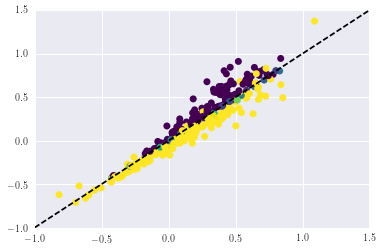

In [280]:
seasons = [
    'spring', 
    'summer', 
    'fall', 
    'winter', 
    'wet', 
    'annual'
]

for season in seasons:
    df = dp[season]
    mu = np.asarray(df.MU_E.values).astype(float)
    tau_ind = np.asarray(mu**(1.-df.B_EVENT) / df.A_EVENT).astype(float)
    alpha = np.asarray(df.ALPHA_H.values).astype(float)
    b_ind = np.asarray(df.B_EVENT).astype(float)
    b_pdf = np.asarray(df.B_pdf).astype(float)
    b_k = np.asarray(df.B).astype(float)
    nu = np.asarray(df.nu_pdf.values).astype(float)
    nu[nu>=99] = np.nan
    nu2 = np.asarray(df.NU_K.values).astype(float)
    nu2[nu2>=99] = np.nan
    b_pdf[nu==np.nan] = np.nan
    
#     nu[b_pdf<1.4] = np.nan
#     nu2[b_pdf>1.6] = np.nan
    
    colors = b_pdf
    plt.scatter(np.log10(nu), np.log10(nu2), c=colors, vmin=1.49, vmax=1.6, cmap=plt.cm.viridis, lw=0)
#     colors = b_pdf
#     plt.scatter(b_k, np.log10(nu/nu2), c=colors, vmin=1.4, vmax=1.6, cmap=plt.cm.viridis, lw=0)
#     plt.scatter(np.log10(mu*365), np.log10(nu), c=colors, vmin=-2.5, vmax=0, cmap=plt.cm.viridis, lw=0)
    
#     colors = np.log10(alpha)
#     plt.scatter(np.log10(nu*mu*365), np.log10(alpha/tau_ind), c=colors, vmin=-1., vmax=.5, cmap=plt.cm.viridis, lw=0)
#     sns.jointplot(np.log10(nu*mu*365), np.log10(alpha/tau_ind), kind='kde')
    
    
x = np.linspace(-1, 1.5, 10)
plt.plot(x, x, 'k--')
    
    
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

(-2, 0.5)

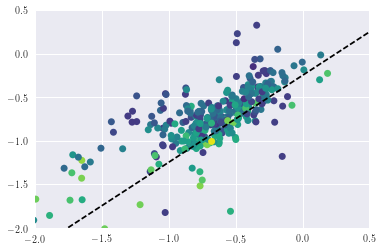

In [367]:
seasons = [
    'spring', 
#     'summer', 
#     'fall', 
    'winter', 
    'wet', 
    'annual'
]

for season in seasons:
    df = dp[season]
    mu = np.asarray(df.MU_E.values).astype(float)
    tau_ind = np.asarray(mu**(1.-df.B_EVENT) / df.A_EVENT).astype(float)
    alpha = np.asarray(df.ALPHA_H.values).astype(float)
    b_ind = np.asarray(df.B_EVENT).astype(float)
    b_pdf = np.asarray(df.B_pdf).astype(float)
    b_k = np.asarray(df.B).astype(float)
    nu = np.asarray(df.nu_pdf.values).astype(float)
    nu[nu>=99] = np.nan
    nu2 = np.asarray(df.NU_K.values).astype(float)
    nu2[nu2>=99] = np.nan
    b_pdf[nu==np.nan] = np.nan
    
#     sns.jointplot(np.log10(alpha/(tau_ind)), np.log10(nu*mu), kind='kde')
    
    colors = b_pdf
    plt.scatter(np.log10(alpha/(tau_ind)), np.log10(nu*mu), c=colors, vmin=.5, vmax=3., cmap=plt.cm.viridis, lw=0)
    
x = np.linspace(-2., .5, 10)
plt.plot(x, x-0.25, 'k--')
plt.xlim(-2., .5)
plt.ylim(-2, .5)

array([ 1.08716379,  1.23244179,  1.85974072,  1.25031395,  0.94020981,
        1.06120792,  1.68718884,  1.7627331 ,  1.71343887,  1.63460408,
        1.75434446,  1.79439568,  1.54244284,  1.63038258,  0.95161485,
        1.37698732,  2.04463711,  0.81308373,  0.96516281,  0.99640948,
        0.97770672,  1.30812634,  1.51451256,  0.91865047,  1.44620733,
        1.77189814,  1.62609037,  1.35772693,  0.9450882 ,  1.01240109,
        1.31887263,  0.97996559,  1.57656127,  1.05709755,  0.93952952,
        0.93139242,  1.03948804,  1.25611078,  1.23934725,  1.22203269,
        1.38805669,  1.70683074,  1.53427636,  1.52847382,  1.29666228,
        2.09622208,  1.37682643,  1.43667424,  1.87251485,  1.35368351,
        2.01051027,  1.41399667,  1.3517974 ,  1.87342235,  1.79283197,
        1.43017615,  1.29358643,  1.75842214,  1.82086099,  2.19106266,
        1.5098683 ,  1.82517042,  2.48574812,  1.7692518 ,  1.98217935,
        1.64675232,  1.44266026,  1.64245796,  0.95754398,  0.91